### В данной домашней работе Вам предстоит отработать следующие 2 навыка: работа с пропущенными значениями и анализ выбросов.

In [1]:
import numpy as np
import pandas as pd

data = pd.read_csv('processed_data_with_new_features.csv', index_col='id')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
data.head()

,vendor_id,passenger_count,store_and_fwd_flag,distance_km,log_trip_duration,anomaly,traffic_jam,day_of_week_1,day_of_week_2,day_of_week_3,...,hour_19,hour_20,hour_21,hour_22,hour_23,month_2,month_3,month_4,month_5,month_6
id,,,,,,,,,,,,,,,,,,,,,
id2875421,1,930.399753,0,1.500479,6.122493,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
id2377394,0,930.399753,0,1.807119,6.498282,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
id3858529,1,NaN,0,6.392080,7.661527,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
id3504673,1,NaN,0,1.487155,6.063785,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
id2181028,1,930.399753,0,1.189925,6.077642,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


Никудышный гном случайно пролил кофе на папку с данными и кодом. К несчастью, из-за этого они с братьями потеряли кучу информации в столбиках **passenger_count** и **distance_km**.

In [3]:
### Выведите количество пропусков в данных колонках
### На всякий случай, проверьте целостность данных в остальных

### Your code is here
print(data[data['passenger_count'].isna()].shape[0], data[data['distance_km'].isna()].shape[0])

145864 145864


In [4]:
round(data['passenger_count'].mode().item(), 5)

930.39975

Начнем с **passenger_count**. Вообще говоря, изначально это была категориальная колонка, к которой мы применили технику OneHotEncoder. Чтобы избавиться от пропусков в данных, конечно, можно просто убрать все объекты, в которых есть пропуски, но тогда мы потеряем ценную информацию. 

Воспользуйтесь относительно простым приемом из лекции: в указанной колонке заполните пропуски самым *популярным* значением среди неотсутствующих.

In [5]:
### Your code is here
data['passenger_count'] = data['passenger_count'].fillna(data['passenger_count'].mode().item())

С колонкой **distance_km** поступим более интересным способом!

Чтобы заполнить пропуск в данной колонке для того или иного объекта, можно находить наиболее похожий на него объект и подглядывать в его значение **distance_km**. Для того, чтобы понять, насколько объекты похожи друг на друга, необходимо использовать Евклидово расстояние между этими самыми объектами в пространстве всех признаков!

С учетом количества объектов в нашем датасете и признаков, посчитать попарные расстояния будет мега-сложно. Поэтому давайте называть объекты похожими, если они принадлежат одной категории, составленной из следующих колонок:

1. vendor_id
2. store_and_fwd_flag
3. traffic_jam
4. month_2
5. month_3
6. month_4
7. month_5
8. month_6

Внутри каждой группы найдите среднее значение признака **distance_km** и заполните NaN'ы в объектах с пропуском в соответствии с тем, к какой категории относится данный объект. Похожее упражнение мы делали на практике в занятии!

**Hint**: достаточно просто взять group by по указанным выше категориальным колонкам и верно вставить полученный результат в исходную табличку.

P.S. Колонки выбраны случайным образом. Можно было взять и другую комбинацию.

In [7]:
### Your code is here
columns = ['vendor_id', 'store_and_fwd_flag', 'traffic_jam', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6']
data['distance_km'] = data['distance_km'].fillna(data.groupby(columns)['distance_km'].transform('mean'))

In [10]:
### Убедимся, что пропусков не осталось

### Your code is here
data.head(20).to_csv('step_7.csv', sep=';', index=False)

### Теперь наши данные чисты! Замерьте качество модели на Кросс-Валидации

In [11]:
from sklearn.model_selection import KFold

selector = KFold(n_splits=4, shuffle=True, random_state=33)

from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error

### Your code is here
X = data.drop('log_trip_duration', axis=1)
y = data['log_trip_duration']

model = LinearRegression()
losses = []
for train_idx, test_idx in selector.split(X, y):
    X_fold_train, X_fold_test = X.values[train_idx], X.values[test_idx]
    y_fold_train, y_fold_test = y.values[train_idx], y.values[test_idx]

    model.fit(X_fold_train, y_fold_train)
    y_fold_pred = model.predict(X_fold_test)
    loss = np.mean((y_fold_pred - y_fold_test)**2)
    losses.append(loss)

cross_val_error = np.mean(losses)
print(f"MSLE на Кросс-валидации: {round(cross_val_error, 3)}")

MSLE на Кросс-валидации: 0.431


### Проведем анализ выбросов! Нарисуйте ящик с усами и гистограмму для таргетной переменной.

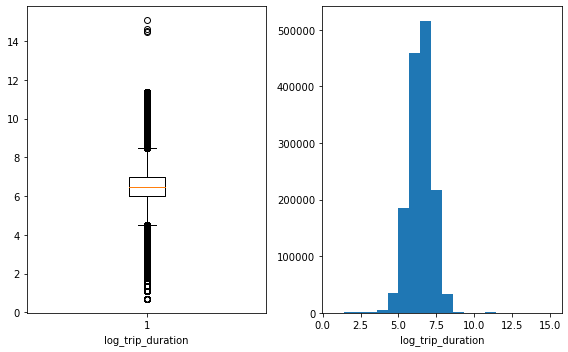

In [15]:
import matplotlib.pyplot as plt

### Your code is here
fig = plt.figure()
fig.set_size_inches(8, 5)

ax1 = fig.add_subplot(1, 2, 1)
ax1.boxplot(data['log_trip_duration'])
ax1.set_xlabel('log_trip_duration')

ax2 = fig.add_subplot(1, 2, 2)
ax2.hist(data['log_trip_duration'], bins=20)
ax2.set_xlabel('log_trip_duration')

fig.tight_layout()


Есть ли, на ваш взгляд, в данных выбросы?

Кажется, что да!

Давайте почистим их, удалив те объекты, таргеты которых находятся вне промежутка

(топ 99,5% значение;   топ 0,5% значение)

In [20]:
### Your code is here
upper = data['log_trip_duration'].quantile(0.995)
lower = data['log_trip_duration'].quantile(0.005)

data_new = data[(data['log_trip_duration'] < upper) & (data['log_trip_duration'] > lower)]

Снова замерьте качество на кросс-валидации, используя старый selector

In [21]:
### Your code is here
X = data_new.drop('log_trip_duration', axis=1)
y = data_new['log_trip_duration']

model = LinearRegression()
losses = []
for train_idx, test_idx in selector.split(X, y):
    X_fold_train, X_fold_test = X.values[train_idx], X.values[test_idx]
    y_fold_train, y_fold_test = y.values[train_idx], y.values[test_idx]

    model.fit(X_fold_train, y_fold_train)
    y_fold_pred = model.predict(X_fold_test)
    loss = np.mean((y_fold_pred - y_fold_test)**2)
    losses.append(loss)

cross_val_error = np.mean(losses)
print(f"MSLE на Кросс-валидации: {round(cross_val_error, 3)}")

MSLE на Кросс-валидации: 0.35
